In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import regex as re
import nltk
from sklearn.ensemble import RandomForestClassifier
import pythainlp.tokenize
import unicodedata
import unidecode
import jieba
import fugashi
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/sbg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data

In [2]:
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [3]:
df.drop_duplicates(inplace=True)
# Remove duplicates
df.rename(columns={'Text': 'text'}, inplace=True)
# Standardize column names
df['language'] = df['language'].replace({'Portugese': 'Portuguese'})
# Fix spelling in data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21859 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      21859 non-null  object
 1   language  21859 non-null  object
dtypes: object(2)
memory usage: 512.3+ KB


## Languages In The Dataset

In [4]:
df["language"].unique()

array(['Estonian', 'Swedish', 'Thai', 'Tamil', 'Dutch', 'Japanese',
       'Turkish', 'Latin', 'Urdu', 'Indonesian', 'Portuguese', 'French',
       'Chinese', 'Korean', 'Hindi', 'Spanish', 'Pushto', 'Persian',
       'Romanian', 'Russian', 'English', 'Arabic'], dtype=object)

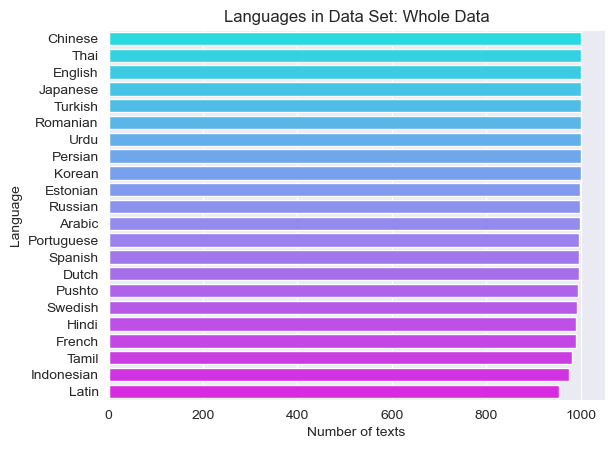

In [5]:
languages = df["language"].value_counts().reset_index()
languages.columns = ["Language", "Freq"]
sns.set_style("darkgrid")
plt.title("Languages in Data Set: Whole Data")
plt.ylabel("Language")
plt.xlabel("Number of texts")
sns.barplot(languages, y="Language", x="Freq", palette="cool")
plt.show()

The dataset it too large to handle locally, so I randomly chose 10,000 texts

In [6]:
df = df.sample(10000, random_state=42)
df.sample(5)

,text,language
3384,sedes europaea tuendis iuribus fundamentalibus...,Latin
6291,christianus fredericus hansen danice christian...,Latin
4428,ถ้าเป็นตัวสะกด ให้ถือตัวหน้าเป็นตัวสะกดแต่ตัวเ...,Thai
6605,buzzy hellring d class of key developer of u...,English
12142,لمړی گڼه یی په کی په چاپ ورسیده پدی وخت کی دد...,Pushto


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3186 to 7670
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10000 non-null  object
 1   language  10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


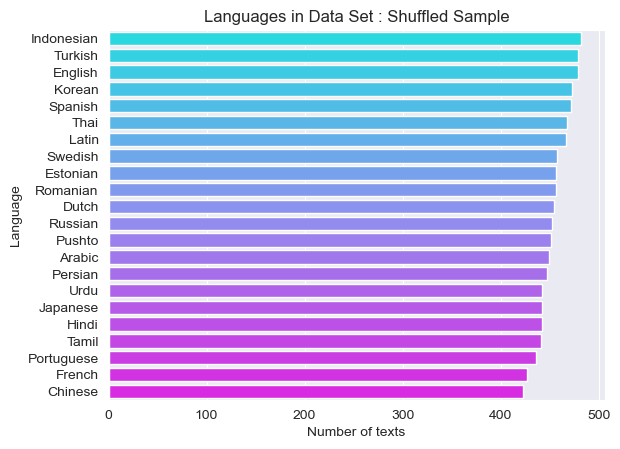

In [8]:
languages = df["language"].value_counts().reset_index()
languages.columns = ["Language", "Freq"]

sns.set_style("darkgrid")
plt.title("Languages in Data Set : Shuffled Sample")
plt.ylabel("Language")
plt.xlabel("Number of texts")
sns.barplot(languages, y="Language", x="Freq", palette="cool")
plt.show()

## Standardize Texts

In [9]:
# Removes punctuation, numbers, extra spaces from texts
def removepunct(s):
    s = re.sub(r'[^\w\s]', ' ', s)
    s = re.sub(r'[0-9]', ' ', s)
    s = re.sub(r' +', ' ', s)
    s = s.lower()
    return s
# Some texts in other scripts contain english characters, for example when citing emails or popular western culture phrases
def remove_engl(s):
    s = re.sub(r'[a-zA-Z]', ' ', s)
    return s
df["text"] = df["text"].apply(removepunct)
df["text"] = df.apply(
    lambda row: remove_engl(row['text']) if row['language'] in ['Chinese', 'Thai', 'Japanese', 'Urdu', 'Persian', 'Russian', 'Arabic', 'Pushto', 'Hindi', 'Tamil' ] else row['text'],
    axis=1
)
# By removing the above, it returns a small handful  of empty strings
df = df[df['text'].str.strip().astype(bool)]
df.sample(n=10, random_state=1)

,text,language
13239,حمله شیمیایی در حومه دمشق بویژه غوطه شرقی و غر...,Persian
31,de a lungul vieții watson a fost interesat de ...,Romanian
21817,บททดสอบแรกพระนวกะ เมื่อท่านได้ไปถึงวัดป่าบ้านต...,Thai
9218,川普在年第一次公开表达对竞选公职的兴趣 他在年赢得了两场改革党的總統初选 但在早期就退出了竞...,Chinese
9617,leopold overstelpte haar met geschenken waaron...,Dutch
5948,för att komma till lund med flyg är malmö airp...,Swedish
12744,عوامی جمہوریہ بینن ف...,Urdu
8930,dicho nombre nace de las reverencias tres cada...,Spanish
20662,este membru al uniunii scriitorilor din români...,Romanian
4851,valla pindala on km aasta seisuga elas vallas ...,Estonian


# Extracting Features of Languages

Extract features such as the average length of words in the text, the number of words in the text, and the number of characters in the text.

In [10]:
features = df.copy()
def avg_word_len(text, lang):
    if lang == 'Thai':
        words = pythainlp.tokenize.word_tokenize(text)
    elif lang == 'Chinese':
        words = list(jieba.cut(text, cut_all=False))
    elif lang == 'Japanese':
        words = [str(w) for w in fugashi.Tagger()(text)]
    else:
        words = nltk.word_tokenize(text)
    return sum(len(word) for word in words) / len(words)
    
def sent_len(text, lang):
    if lang == 'Thai':
        words = pythainlp.tokenize.word_tokenize(text)
    elif lang == 'Chinese':
        words = list(jieba.cut(text, cut_all=False))
    elif lang == 'Japanese':
        words = [str(w) for w in fugashi.Tagger()(text)]
    else:
        words = nltk.word_tokenize(text)
    return len(words)
def char_len(text, lang):
    return len(text)

features["avg_word_len"] =  features.apply(lambda x: avg_word_len(x['text'], x['language']), axis=1)
features["sent_len"] = features.apply(lambda x: sent_len(x['text'], x['language']), axis=1)
features["char_len"] = features.apply(lambda x: char_len(x['text'], x['language']), axis=1)
features  = features.sort_values('language')
features.sample(n=10)


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/y3/ph_dk0xn09n503mvdjfq9r1h0000gn/T/jieba.cache
Loading model cost 0.238 seconds.
Prefix dict has been built successfully.


,text,language,avg_word_len,sent_len,char_len
9379,efter det fick hon titelrollen i upn serien ve...,Swedish,4.962963,81,482
19144,en septembre personnes par jour succombent à l...,French,5.421569,102,654
19920,ـــ په م نیټه دبرگمتال ولسوالۍ د بدين شاه په س...,Pushto,3.927273,55,270
15026,de keyser werd in stadsarchitect en stadssteen...,Dutch,5.450549,91,586
4156,le chien dartois est un descendant direct en t...,French,4.583333,48,268
16050,கரைச்சி பிரதேச சபைப் பகுதி வட்டாரங்களாகப் பிரி...,Tamil,9.157895,19,192
412,ما شربرم جسے بھی کہا جاتا ہے گلگت بلتستان کے...,Urdu,3.454545,44,198
19125,le cas des variétés de dimension en est encore...,French,4.810127,79,458
13047,novembril vabastas vabariigi valitsus hermann...,Estonian,6.066667,60,424
17234,la historia del departamento de caldas está ba...,Spanish,4.368421,38,203


### Visualizing the Features across languages

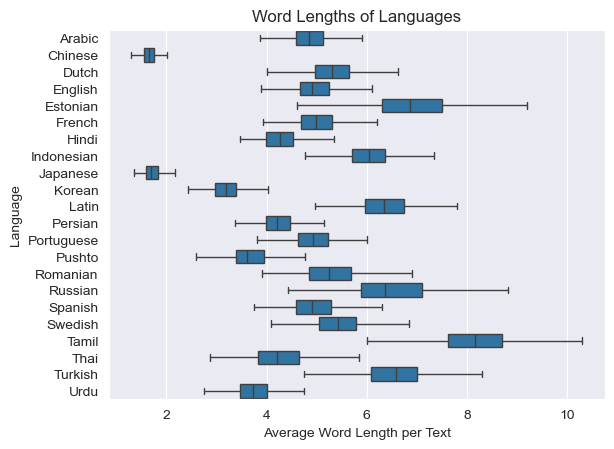

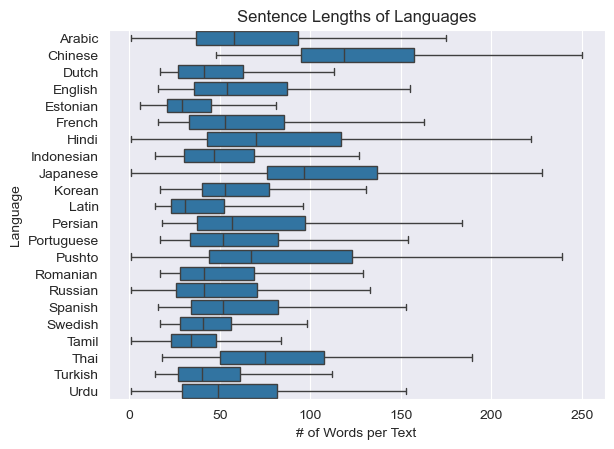

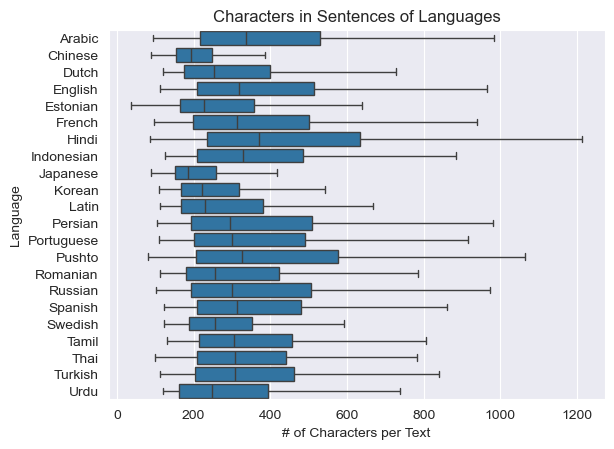

In [11]:
sns.boxplot(data=features, y='language', x='avg_word_len', showfliers=False)
plt.title("Word Lengths of Languages")
plt.xlabel("Average Word Length per Text")
plt.ylabel("Language")
plt.show()
sns.boxplot(data=features, y='language', x='sent_len', showfliers=False)
plt.title("Sentence Lengths of Languages")
plt.xlabel("# of Words per Text")
plt.ylabel("Language")
plt.show()
sns.boxplot(data=features, y='language', x='char_len', showfliers=False)
plt.title("Characters in Sentences of Languages")
plt.xlabel("# of Characters per Text")
plt.ylabel("Language")
plt.show()

### Distribution of Features of Languages

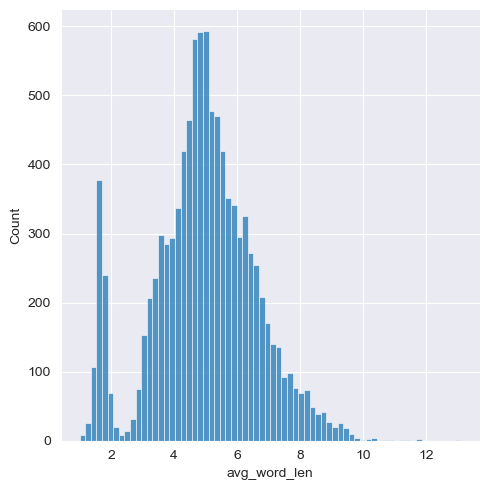

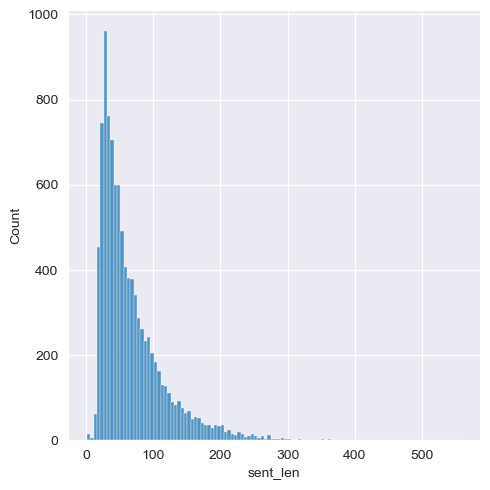

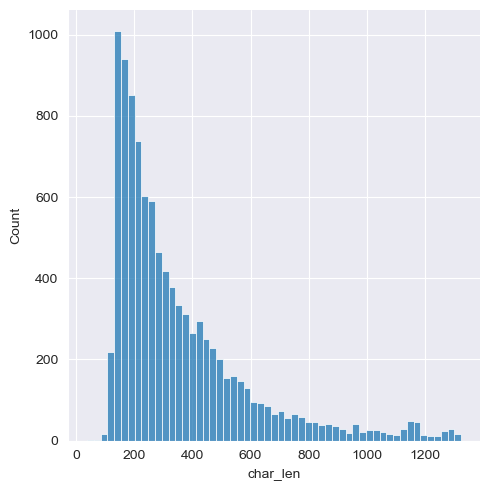

In [12]:
sns.displot(features["avg_word_len"])
plt.show()
sns.displot(features["sent_len"])
plt.show()
sns.displot(features["char_len"])
plt.show()

### Analyzing Averages of the Features Across Languages

In [13]:
language_averages = features.groupby('language')[['avg_word_len', 'sent_len', 'char_len']].mean().reset_index()
language_averages


,language,avg_word_len,sent_len,char_len
0,Arabic,4.862517,70.184855,413.750557
1,Chinese,1.648880,137.945238,224.080952
2,Dutch,5.334425,51.680617,323.198238
3,English,4.981286,66.006263,390.561587
4,Estonian,6.970905,37.571116,294.608315
5,French,5.059661,65.995316,395.194379
6,Hindi,4.295533,87.509174,464.380734
7,Indonesian,6.038727,54.489627,381.213693
8,Japanese,1.750766,112.310502,219.369863
9,Korean,3.261876,63.513742,266.310782


In [14]:
max_word_len = language_averages.loc[language_averages['avg_word_len'].idxmax()]
min_word_len = language_averages.loc[language_averages['avg_word_len'].idxmin()]
max_sent_len = language_averages.loc[language_averages['sent_len'].idxmax()]
min_sent_len = language_averages.loc[language_averages['sent_len'].idxmin()]
max_char_count = language_averages.loc[language_averages['char_len'].idxmax()]
min_char_count = language_averages.loc[language_averages['char_len'].idxmin()]
print("Longest average word length:", max_word_len['language'], "→", round(max_word_len['avg_word_len'], 2))
print("Shortest average word length:", min_word_len['language'], "→", round(min_word_len['avg_word_len'], 2))
print("Most words per sentence:", max_sent_len['language'], "→", round(max_sent_len['sent_len'], 2))
print("Fewest words per sentence:", min_sent_len['language'], "→", round(min_sent_len['sent_len'], 2))

print("Most characters per sentence:", max_char_count['language'], "→", round(max_char_count['char_len'], 2))
print("Fewest characters per sentence:", min_char_count['language'], "→", round(min_char_count['char_len'], 2))

Longest average word length: Tamil → 8.14
Shortest average word length: Chinese → 1.65
Most words per sentence: Chinese → 137.95
Fewest words per sentence: Estonian → 37.57
Most characters per sentence: Hindi → 464.38
Fewest characters per sentence: Japanese → 219.37


# Machine Learning Prediction Model

CountVector takes a text and creates a matrix of token counts.

I used two different methods of CountVector. For languages that are written in latin script, it uses the default CountVector which analyzes by words. However, for languages not written in latin script, I analyze by characters which creates a matrix of characters used in the text.

I also chose to use a Multinominal Naive Bayes methods.

In [ ]:
#Standardize the label of languages to numerical
le= LabelEncoder()
df["language"] = le.fit_transform(df["language"])

['Indonesian' 'English' 'Swedish' ... 'Korean' 'Japanese' 'Pushto']


### Analyze by Words

In [16]:
cv_w = CountVectorizer()
X_w = cv_w.fit_transform(df["text"]).toarray()
y_w = df["language"]
x_train_w , x_test_w ,y_train_w, y_test_w = train_test_split(X_w ,y_w, test_size = 0.2, random_state = 42)
cv_model_w= MultinomialNB().fit(x_train_w, y_train_w)
y_pred_cv_w= cv_model_w.predict(x_test_w)

### Analyze by Characters

In [17]:
cv_c= CountVectorizer(analyzer="char")
X_c = cv_c.fit_transform(df["text"]).toarray()
y_c = df["language"]
x_train_c, x_test_c,y_train_c, y_test_c= train_test_split(X_c,y_c, test_size = 0.2, random_state = 42)
cv_model_c= MultinomialNB().fit(x_train_c, y_train_c)
y_pred_cv_c= cv_model_c.predict(x_test_c)

### Prediction Functions

In [18]:
def is_latin(s):
    for char in s:
        if not char.isalpha():
            continue
        if 'LATIN' not in unicodedata.name(char, ''):
            return False
    return True

In [19]:
def prediction_cv(text):
    text = removepunct(text)
    if is_latin(text):
        x = cv_w.transform([text])
        pred = cv_model_w.predict(x)
        lang = le.inverse_transform(pred)
        print(f"Language: {lang[0]}")
    else:
        x = cv_c.transform([text])
        pred = cv_model_c.predict(x)
        lang = le.inverse_transform(pred)
        print(f"Language: {lang[0]}")

## How Well Do The Models Do

In [20]:
data = [[0]*4 for _ in range(2)]
result_df = pd.DataFrame(data=data, columns=["Accuracy", "Precision", "Recall", "F1-Score"], index=["By_Word", "By_Char"])
def results(y_pred, y_test):
    return [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')]
result_df.loc["By_Word", :] = results( y_pred_cv_w, y_test_w)
result_df.loc["By_Char", :] = results( y_pred_cv_c, y_test_c)
result_df


,Accuracy,Precision,Recall,F1-Score
By_Word,0.962851,0.969238,0.962851,0.962083
By_Char,0.975402,0.977959,0.975402,0.975756


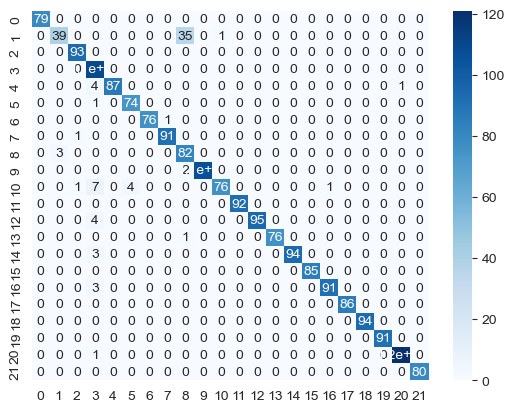

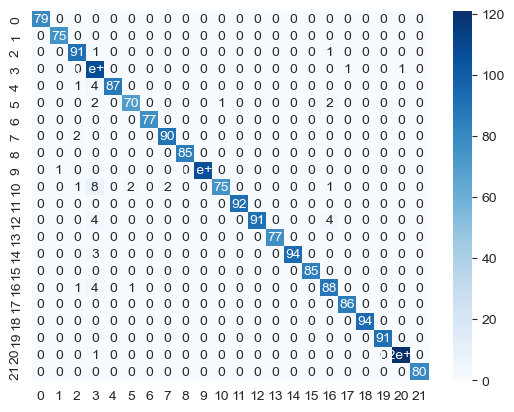

In [26]:


cword  = confusion_matrix(y_test_w, y_pred_cv_w)
sns.heatmap(cword, cmap = "Blues", annot=True)
plt.show()
cchar  = confusion_matrix(y_test_c, y_pred_cv_c)
sns.heatmap(cchar, cmap = "Blues", annot=True)
plt.show()